In [1]:
import h5py
import os
import numpy as np
import pandas as pd
from scipy.io import savemat
import matplotlib.pyplot as plt
from src.dataloader.transforms import BandPassFilter, Spline_interpolation

In [2]:
IN_DIR = "code/raw_test/data"
OUT_BASE = "data"
OUT_SPLIT = "split_csvs"
OUT_ECGS = "processed_data"
DS_NAME = "Code15_test"
#DS_NAME = "Code15"

## Test

In [3]:
with h5py.File(os.path.join(IN_DIR, "ecg_tracings.hdf5")) as f:
    x = f["tracings"]
    xx = np.asarray(x, dtype=np.float64)

In [4]:
xx.shape

(827, 4096, 12)

In [5]:
x = np.arange(xx.shape[1])

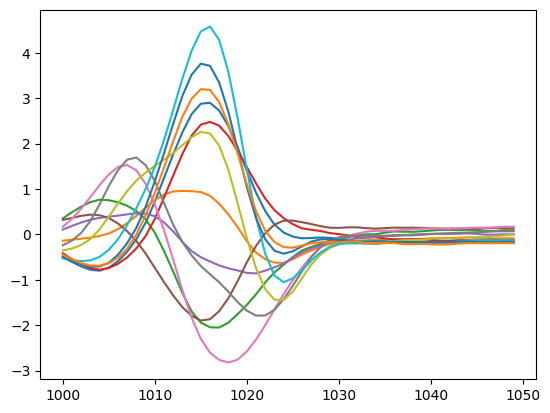

In [6]:
for j in range(xx.shape[-1]):
    plt.plot(x[1000:1050], xx[0, 1000:1050, j])

In [7]:
bpf = BandPassFilter(fs=400)
ecg = bpf(xx[0].T)

In [8]:
ecg.shape

(12, 4096)

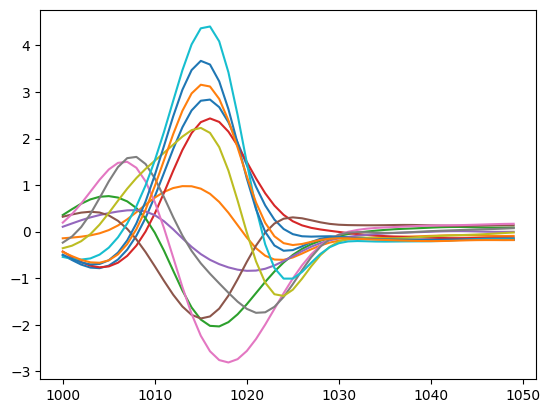

In [9]:
for j in range(ecg.shape[0]):
    plt.plot(x[1000:1050], ecg[j, 1000:1050])

In [10]:
si = Spline_interpolation(fs_new=250, fs_old=400)
ecg = si(ecg)

In [11]:
ecg.shape

(12, 2560)

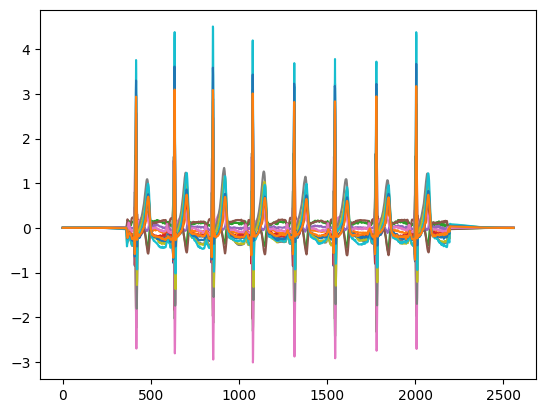

In [12]:
for j in range(ecg.shape[0]):
    plt.plot(x[:ecg.shape[1]], ecg[j, :])

## Class mappings

/home/zoorab/12-lead-ecg-classifier/data/processed_data/CPSC_CPSC_Extra/A0244_preprocessed.mat,62,Female,250,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
The  csv files  all have 6 columns 1dAVb, RBBB, LBBB, SB, AF, ST
path,age,gender,fs,426783006,426177001,164934002,427393009,713426002,427084000,59118001,164889003,59931005,47665007,445118002,39732003,164890007,164909002,270492004,251146004,284470004
e.g. all "prolonged pr interval" will be merged to "1st degree heart block" (Physionet mapping)
first_degree_hb_snomed = '270492004'
prolonged_pr_snomed = '164947007'

In [3]:
rename2snomed = {"1dAVb": "270492004",
                 "RBBB": "59118001",
                 "LBBB": "164909002",
                 "SB": "426177001",
                 "AF": "164889003",
                 "ST": "427084000"}

In [4]:
csv_header = ['path', 'age', 'gender', 'fs',
              '426783006', '426177001', '164934002', '427393009',
              '713426002', '427084000', '59118001', '164889003',
              '59931005', '47665007', '445118002', '39732003',
              '164890007', '164909002', '270492004', '251146004', '284470004']

In [15]:
class_mask = [k in rename2snomed.values() for k in csv_header[4:]]

In [16]:
class_mask

[False,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False]

## Code15 test

In [17]:
mat_path = os.path.join(OUT_BASE, OUT_ECGS, DS_NAME)
os.makedirs(mat_path, exist_ok=True)

In [18]:
bpf = BandPassFilter(fs=400)
si = Spline_interpolation(fs_new=250, fs_old=400)

In [19]:
with h5py.File(os.path.join(IN_DIR, "ecg_tracings.hdf5")) as f:
    x = f["tracings"]
    xx = np.asarray(x, dtype=np.float64)

In [20]:
out_files = []
for j in range(xx.shape[0]):
    ecg = bpf(xx[j].T)
    ecg = si(ecg)
    out_fn = os.path.join(mat_path, f"T{j:04d}.mat" )
    savemat(out_fn, {"val" : ecg})
    out_files.append(out_fn)

In [21]:
df = pd.read_csv(os.path.join(IN_DIR, "attributes.csv"))

In [22]:
df["path"] = pd.Series(out_files)

In [23]:
sex2 = ["Male" if s == "M" else "Female" for s in df["sex"]]

In [24]:
df["gender"] = pd.Series(sex2)

In [25]:
df["fs"] = 250

In [26]:
df.head()

,age,sex,path,gender,fs
0,34,M,data/processed_data/Code15_test/T0000.mat,Male,250
1,70,F,data/processed_data/Code15_test/T0001.mat,Female,250
2,52,F,data/processed_data/Code15_test/T0002.mat,Female,250
3,41,F,data/processed_data/Code15_test/T0003.mat,Female,250
4,32,F,data/processed_data/Code15_test/T0004.mat,Female,250


In [27]:
df2 = pd.read_csv(os.path.join(IN_DIR, "annotations", "gold_standard.csv"))

In [28]:
df2 = df2.rename(columns=rename2snomed)

In [29]:
df2.head()

,270492004,59118001,164909002,426177001,164889003,427084000
0,0,0,0,0,0,0
1,0,0,1,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [30]:
df2.sum()

270492004    28
59118001     34
164909002    30
426177001    16
164889003    13
427084000    37
dtype: int64

In [31]:
df = df.merge(df2, left_index=True, right_index=True)

In [32]:
for k in csv_header[4:]:
    if k not in rename2snomed.values():
        df[k] = 0

In [33]:
df[csv_header].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 827 entries, 0 to 826
Data columns (total 21 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   path       827 non-null    object
 1   age        827 non-null    int64 
 2   gender     827 non-null    object
 3   fs         827 non-null    int64 
 4   426783006  827 non-null    int64 
 5   426177001  827 non-null    int64 
 6   164934002  827 non-null    int64 
 7   427393009  827 non-null    int64 
 8   713426002  827 non-null    int64 
 9   427084000  827 non-null    int64 
 10  59118001   827 non-null    int64 
 11  164889003  827 non-null    int64 
 12  59931005   827 non-null    int64 
 13  47665007   827 non-null    int64 
 14  445118002  827 non-null    int64 
 15  39732003   827 non-null    int64 
 16  164890007  827 non-null    int64 
 17  164909002  827 non-null    int64 
 18  270492004  827 non-null    int64 
 19  251146004  827 non-null    int64 
 20  284470004  827 non-null    int64

In [34]:
csv_path = os.path.join(OUT_BASE, OUT_SPLIT, DS_NAME)
os.makedirs(csv_path, exist_ok=True)

In [35]:
df[csv_header].to_csv(os.path.join(csv_path, "all_ecgs.csv"), index=None, sep=',')

## Code 15 full

In [5]:
IN_DIR = "code/raw"
DS_NAME = "Code15"

In [6]:
mat_path = os.path.join(OUT_BASE, OUT_ECGS, DS_NAME)
os.makedirs(mat_path, exist_ok=True)

In [7]:
def examid2filename(eid, mat_path=mat_path):
    return os.path.join(mat_path, f"E{eid:08d}.mat" )

In [50]:
bpf = BandPassFilter(fs=400)
si = Spline_interpolation(fs_new=250, fs_old=400)

In [52]:
for i in range(18):
    fn = os.path.join(IN_DIR,f"exams_part{i}.hdf5")
    print(fn)
    with h5py.File(fn) as f:
        xx = np.asarray(f["tracings"], dtype=np.float64)
        exam_id = np.asarray(f["exam_id"], dtype=np.int64)
        for j in range(exam_id.shape[0]):
            ecg = bpf(xx[j].T)
            ecg = si(ecg)
            out_fn = examid2filename(exam_id[j], mat_path)
            savemat(out_fn, {"val" : ecg})

code/raw/exams_part0.hdf5
code/raw/exams_part1.hdf5
code/raw/exams_part2.hdf5
code/raw/exams_part3.hdf5
code/raw/exams_part4.hdf5
code/raw/exams_part5.hdf5
code/raw/exams_part6.hdf5
code/raw/exams_part7.hdf5
code/raw/exams_part8.hdf5
code/raw/exams_part9.hdf5
code/raw/exams_part10.hdf5
code/raw/exams_part11.hdf5
code/raw/exams_part12.hdf5
code/raw/exams_part13.hdf5
code/raw/exams_part14.hdf5
code/raw/exams_part15.hdf5
code/raw/exams_part16.hdf5
code/raw/exams_part17.hdf5


In [8]:
df2 = pd.read_csv(os.path.join(IN_DIR, "exams.csv"))

In [9]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345779 entries, 0 to 345778
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   exam_id           345779 non-null  int64  
 1   age               345779 non-null  int64  
 2   is_male           345779 non-null  bool   
 3   nn_predicted_age  345779 non-null  float64
 4   1dAVb             345779 non-null  bool   
 5   RBBB              345779 non-null  bool   
 6   LBBB              345779 non-null  bool   
 7   SB                345779 non-null  bool   
 8   ST                345779 non-null  bool   
 9   AF                345779 non-null  bool   
 10  patient_id        345779 non-null  int64  
 11  death             233647 non-null  object 
 12  timey             233647 non-null  float64
 13  normal_ecg        345779 non-null  bool   
 14  trace_file        345779 non-null  object 
dtypes: bool(8), float64(2), int64(3), object(2)
memory usage: 21.1+ MB


In [10]:
df2["path"] = df2["exam_id"].apply(examid2filename)

In [11]:
sex2 = ["Male" if s else "Female" for s in df2["is_male"]]

In [12]:
df2["gender"] = pd.Series(sex2)

In [15]:
df2["fs"] = 250

In [16]:
df2.head()

,exam_id,age,is_male,nn_predicted_age,1dAVb,RBBB,LBBB,SB,ST,AF,patient_id,death,timey,normal_ecg,trace_file,path,gender,fs
0,1169160,38,True,40.160484,False,False,False,False,False,False,523632,False,2.098628,True,exams_part13.hdf5,data/processed_data/Code15/E01169160.mat,Male,250
1,2873686,73,True,67.059440,False,False,False,False,False,False,1724173,False,6.657529,False,exams_part13.hdf5,data/processed_data/Code15/E02873686.mat,Male,250
2,168405,67,True,79.621740,False,False,False,False,False,True,51421,False,4.282188,False,exams_part13.hdf5,data/processed_data/Code15/E00168405.mat,Male,250
3,271011,41,True,69.750260,False,False,False,False,False,False,1737282,False,4.038353,True,exams_part13.hdf5,data/processed_data/Code15/E00271011.mat,Male,250
4,384368,73,True,78.873460,False,False,False,False,False,False,331652,False,3.786298,False,exams_part13.hdf5,data/processed_data/Code15/E00384368.mat,Male,250


In [17]:
for k, v in rename2snomed.items():
    df2[v] = df2[k].astype(int)

In [18]:
for k in csv_header[4:]:
    if k not in rename2snomed.values():
        df2[k] = 0

In [19]:
csv_path = os.path.join(OUT_BASE, OUT_SPLIT, DS_NAME)
os.makedirs(csv_path, exist_ok=True)

In [61]:
df2[csv_header].to_csv(os.path.join(csv_path, "all_ecgs.csv"), index=None, sep=',')

In [62]:
df2[["exam_id", "patient_id"]].to_csv(os.path.join(csv_path, "patient_ids.csv"), index=None, sep=',')

## Patients

In [20]:
ecg_count = df2.groupby("patient_id").size()

In [21]:
ecg_count.max()

np.int64(38)

([<matplotlib.axis.XTick at 0x7f2bcfd27820>,
 [Text(1.5, 0, '1'),
  Text(2.5, 0, '2'),
  Text(3.5, 0, '3'),
  Text(4.5, 0, 'more')])

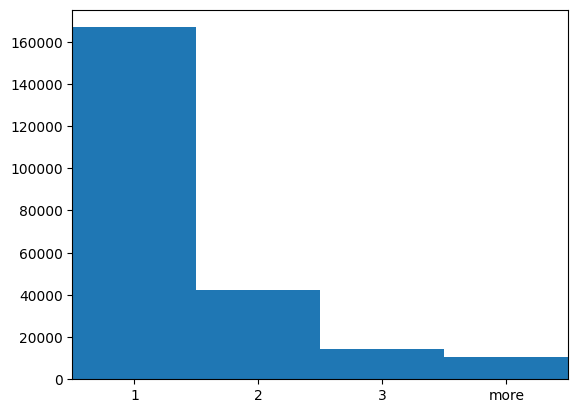

In [22]:
plt.hist(ecg_count, bins=[1, 2, 3, 4, 40])
plt.xlim(1, 5)
plt.xticks([1.5, 2.5, 3.5, 4.5], ["1", "2", "3", "more"])

In [23]:
df_unique = df2.groupby("patient_id").head(1)

In [24]:
df_unique.shape

(233770, 35)

In [27]:
df_20p = df_unique.sample(frac=0.2)

In [29]:
df_20p[csv_header].to_csv(os.path.join(csv_path, "ecgs_patients_20_percent.csv"), index=None, sep=',')

In [30]:
df_4p = df_20p.sample(frac=0.2)

In [32]:
df_4p[csv_header].to_csv(os.path.join(csv_path, "ecgs_patients_04_percent.csv"), index=None, sep=',')

In [33]:
# old code: join on patients (non-unique)
#df2.join(patients_20p.rename("dummy"), how="right", on="patient_id")[csv_header].to_csv(os.path.join(csv_path, "ecgs_patients_20_percent.csv"), index=None, sep=',')